# Imports

In [1]:
#Data Manipulation Librairies
import pandas as pd
from pandas.plotting import scatter_matrix, andrews_curves

from datetime import datetime

from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from collections import defaultdict

import numpy as np
import scipy.stats as st
import scipy
import scipy.io

from itertools import product

from skimage import io, transform

import PIL
from PIL import Image
from PIL import ImageOps

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

import pdb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

import torchvision
from torchvision import transforms, utils, datasets, models

torch.set_printoptions(linewidth=120)

import re
import copy
import os

import math
import csv

In [2]:
from time import time, sleep
from IPython import get_ipython
from IPython.display import Audio, display, HTML
from ipywidgets import IntProgress

class Beeper:

    def __init__(self, threshold, **audio_kwargs):
        self.threshold = threshold
        self.start_time = None    # time in sec, or None
        self.audio = audio_kwargs

    def pre_execute(self):
        if not self.start_time:
            self.start_time = time()
            

    def post_execute(self):
        end_time = time()
        if self.start_time and end_time - self.start_time > self.threshold:
            audio = Audio(**self.audio, autoplay=True)
            display(audio)
            print((end_time - self.start_time)/60, " minutes.")
        self.start_time = None

beeper = Beeper(5, filename='beep-07.wav')

ipython = get_ipython()
ipython.events.register('pre_execute', beeper.pre_execute)
ipython.events.register('post_execute', beeper.post_execute)



# Class Definitions

In [3]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 4, 5)
        self.conv2 = nn.Conv2d(4, 8, 5)
        self.conv3 = nn.Conv2d(8, 16, 5)
        
        self.fc1 = nn.Linear(in_features =  16*576, out_features = 2000)
        self.fc2 = nn.Linear(in_features = 2000, out_features = 200)
        self.out = nn.Linear(in_features = 200, out_features = 120)


    def forward(self, t):
        
        # (1) input layer
        t = t

        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        #print(t.shape)

        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        #print(t.shape)
        
        # (3.5) hidden conv layer
        t = self.conv3(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        #print(t.shape)

        # (4) hidden linear layer
        #[64, 8, 53, 53]
        #print("before : ", t.shape)
        t = t.view(-1, 16*576)
        #print("after : ", t.shape)
        t = self.fc1(t)
        t = F.relu(t)
        #print(t.shape)
        
        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)
        #print(t.shape)

        # (6) output layer
        t = self.out(t)
        #t = F.softmax(t, dim=1)
        #print(t.shape)

        return t
        #x = F.relu(self.conv1(x))
        #return F.relu(self.conv2(x))
        #return x

# Data

## Data Loading

In [4]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        #print("rescale sample is : ", sample)


        image = sample
        #print(image.size)

        h, w = image.size
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        img = image.resize((new_h, new_w))

        #img = transform.resize(image, (new_h, new_w))

        return img


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        #print("radomcrop sample is : ", sample)
        #print("radomcrop size is : ", sample.size)


        image = sample

        h, w = image.size
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        #print(left, top, top + new_h, left + new_w)
        

        image = image.crop([top, left, top + new_h, left + new_w])
        #print(image.size)
        #image.show()
        return image

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return torch.from_numpy(image)

In [8]:
def load_dataset(path):
    data_path = path
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(),
            Rescale(256),
            RandomCrop(224),
            transforms.ToTensor()
        ])
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=64,
        num_workers=0,
        shuffle=False
    )
    return train_loader

#for batch_idx, (data, target) in enumerate(load_dataset()):
    #train network
    
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [9]:
test_list = scipy.io.loadmat('./lists/test_list.mat')
file_list = scipy.io.loadmat('./lists/file_list.mat')
train_list = scipy.io.loadmat('./lists/train_list.mat')

In [10]:
dataset_torch = load_dataset("./Images")

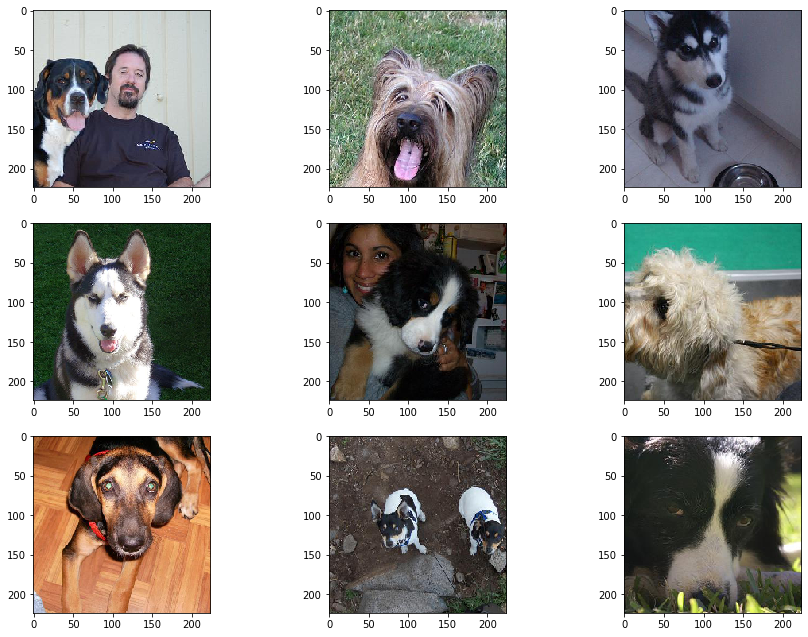

In [26]:
fig = plt.figure(figsize=(15, 15))

for i in range(9):
    ax = fig.add_subplot(4, 3, i+1)
    it = np.random.randint(20000)
    plt.imshow(  dataset_torch.dataset[it][0].permute(1, 2, 0)  )
    


In [27]:
labeled_data = []
for i in range(len(file_list["labels"])):
    if(i > 1):
        if(file_list["labels"][i][0] != file_list["labels"][i-1][0]): print(file_list["labels"][i+1][0])
    labeled_data.append((dataset_torch.dataset[i][0],file_list["labels"][i][0]) )
    

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120


1.2236156821250916  minutes.


## Dataset Creation

In [28]:
train_data, test_data = train_test_split(labeled_data, train_size = 0.85, shuffle = True)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [29]:
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=64,
                                           num_workers=0,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size=64,
                                           num_workers=0,
                                           shuffle=True)

In [30]:
mini_train_loader = torch.utils.data.DataLoader(train_data[:2048],
                                           batch_size=32,
                                           num_workers=0,
                                           shuffle=True)
mini_test_loader = torch.utils.data.DataLoader(test_data[:256],
                                           batch_size=32,
                                           num_workers=0,
                                           shuffle=True)

# Rookie Self Taught

In [32]:
#Parameters list

parameters = dict(
    batch_size_list = [30, 100, 500],
    lr_list = [.5, 0.1, .05],
    step_size = [0.5*len(mini_train_loader), len(mini_train_loader), 3*len(mini_train_loader)]
)
param_values = [v for v in parameters.values()]

network = Network()

In [33]:
def cyclical_lr(stepsize, min_lr, max_lr):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1.

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

def step_decay_schedule( step_size=10, initial_lr=1e-3, decay_factor=0.75):
    
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    return initial_lr * (decay_factor ** np.floor(epoch/step_size))

The formula to be used to measure the padding value to get the spatial size of the input and output volume to be the same with stride 1 is
(k - 1)/2 where K is the filter size.
Finally, the formula to calculate the output size is equal to
𝑂=((𝑊−𝐾+2𝑃)/𝑆)+1
where O is the output height/length, W is the input height/length, K is the filter size, P is the padding, and S is the stride.
For example, if we take S=1, P=2 with W=200 and K=5 and using 40 filters, then the output size will 200×200×40 using the above formula.
On the other hand if we use 𝑆=1,𝑃=1, then the output size would be 198×198×40.
I know it is a lengthy answer but just wanted to clarify how filter size, stride and padding work to control the output size in a convolutional layer.

## Single Parameter combination

In [39]:
network = Network()
step_size = 2*len(mini_train_loader)
start_lr = 0.5
optimizer = torch.optim.SGD(network.parameters(), start_lr)

for g in optimizer.param_groups:
    g['lr'] == 0.01
    
max_lr = 0.5
min_lr = 0.01
clr = cyclical_lr(step_size, min_lr, max_lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])
k = 0


criterion = nn.CrossEntropyLoss()

total_loss = 0
total_correct = 0

lr_find_loss = []
lr_find_lr = []

itera = 0

smoothing = 0.05

for epoch in range(15):
    print("epoch ", epoch, "--"*10)
    
    for phase in ['train', 'val']:
        
        if phase == 'train':
            network.train()
        else: 
            network.eval()
        
        running_loss = 0.0
        running_corrects = 0
        total_loss = 0

        for batch in mini_train_loader:  # Get Batch
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase == 'train'):
                images, labels = batch
                labels = labels - 1
                preds = network(images)

                loss = F.cross_entropy(preds, labels.long())  # Calculate Loss
                
                if phase == 'train':
                    loss.backward()  # Calculate Gradients
                    optimizer.step()  # Update Weights
                    
            running_loss += loss.item() * images.size(0)
            running_corrects += get_num_correct(preds, labels)

            if phase == 'train':
                scheduler.step()
               # if iter == 20 :
               #     for g in optimizer.param_groups:
                #        g['lr'] = 0.001

                if itera % (step_size*2) == 0 : 
                    #max_lr = max_lr * 0.8
                    max_lr = max_lr * np.exp(-1*(0.1 + ((1/10)*k)))
                    k += 1
                    clr = cyclical_lr(step_size, min_lr, max_lr)
                    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])
                lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
                lr_find_lr.append(lr_step)

                if itera==0:
                  lr_find_loss.append(loss)
                else:
                  loss = smoothing  * loss + (1 - smoothing) * lr_find_loss[-1]
                  lr_find_loss.append(loss)
                itera += 1
                
        if(phase == 'val'):
            preds_files = []
            labels_files = []
            for batch in mini_test_loader:
                images, labels = batch
                preds = network(images)
                _, out = torch.max(preds, 1)
                preds_files.append(out)
                labels_files.append(labels.data - 1)

            sums = 0
            pre = 0
            for i in range(len(preds_files)):
                sums += torch.sum(preds_files[i] == labels_files[i]).item() + 1
                pre += precision_score(np.array(preds_files[i]), np.array(labels_files[i]), average = 'macro')

            print('percentage accuracy test data : ', sums/len(mini_test_loader.dataset))
                
            #if iter % 10 == 0 : print(iter, " : ", lr_step)
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = running_corrects / len(train_loader)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        phase, epoch_loss, epoch_acc))
            

    total_loss += loss.item()
    total_correct += get_num_correct(preds, labels)
    
    print("epoch", epoch, "total_correct:", total_correct, "loss:", total_loss, '\n')

epoch  0 --------------------
train Loss: 35.7810 Acc: 0.0876
percentage accuracy test data :  0.0390625
val Loss: 35.7501 Acc: 0.0766
epoch 0 total_correct: 0 loss: 4.793376922607422 

epoch  1 --------------------
train Loss: 35.7511 Acc: 0.0949
percentage accuracy test data :  0.03515625
val Loss: 35.6226 Acc: 0.1204
epoch 1 total_correct: 1 loss: 4.752741813659668 

epoch  2 --------------------
train Loss: 35.7137 Acc: 0.0949
percentage accuracy test data :  0.04296875
val Loss: 35.6280 Acc: 0.1022
epoch 2 total_correct: 2 loss: 4.7355194091796875 

epoch  3 --------------------
train Loss: 35.6214 Acc: 0.0949
percentage accuracy test data :  0.04296875
val Loss: 35.5579 Acc: 0.1022
epoch 3 total_correct: 3 loss: 4.795997142791748 

epoch  4 --------------------
train Loss: 35.5634 Acc: 0.1058
percentage accuracy test data :  0.04296875
val Loss: 35.5667 Acc: 0.1022
epoch 4 total_correct: 4 loss: 4.722723007202148 

epoch  5 --------------------
train Loss: 35.6007 Acc: 0.1168
per

8.436830997467041  minutes.


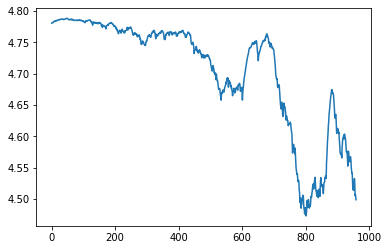

In [40]:
plt.plot(lr_find_loss)

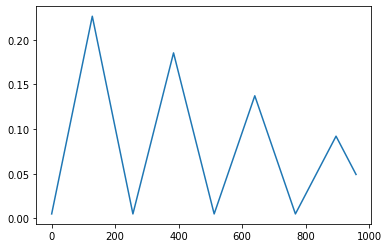

In [41]:
plt.plot(lr_find_lr)

In [56]:
len(mini_test_loader.dataset)

256

In [57]:
preds_files = []
labels_files = []
for batch in mini_test_loader:
    images, labels = batch
    preds = network(images)
    _, out = torch.max(preds, 1)
    print(len(out ))
    preds_files.append(out)
    labels_files.append(labels.data - 1)

32
32
32
32
32
32
32
32


In [58]:
sums = 0
pre = 0
for i in range(len(preds_files)):
    sums += torch.sum(preds_files[i] == labels_files[i]).item() + 1
    pre += precision_score(np.array(preds_files[i]), np.array(labels_files[i]), average = 'macro')

print(sums)
print(sums/128)
print(pre/4)

13
0.1015625
0.021626919998768736


## Multiple Parameter combination

In [59]:
all_params_loss = []
for batch_size, max_lr, step_size in product(*param_values): 

    print(f' batch_size={batch_size} lr={max_lr} step_size={step_size}')
    comment = f' batch_size={batch_size} lr={max_lr} step_size={step_size}'
    network = Network()

    start_lr = 0.5
    optimizer = torch.optim.SGD(network.parameters(), start_lr)
    for g in optimizer.param_groups:
        g['lr'] == 0.01

    min_lr = 0.01
    clr = cyclical_lr(step_size, min_lr, max_lr)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])

    #train_loader = torch.utils.data.DataLoader(labeled_data,
    #                                           batch_size=batch_size,
    #                                           num_workers=0,
    #                                           shuffle=True)


    criterion = nn.CrossEntropyLoss()

    total_loss = 0
    total_correct = 0

    lr_find_loss = []
    lr_find_lr = []

    iter = 0

    smoothing = 0.05

    for epoch in range(10):

        total_loss = 0
        total_correct = 0

        for batch in mini_train_loader:  # Get Batch
            images, labels = batch
            labels = labels - 1
            preds = network(images)  # Pass Batch
            #print(labels)
            loss = F.cross_entropy(preds, labels.long())  # Calculate Loss

            optimizer.zero_grad()
            loss.backward()  # Calculate Gradients
            optimizer.step()  # Update Weights

            scheduler.step()
           # if iter == 20 :
           #     for g in optimizer.param_groups:
            #        g['lr'] = 0.001

            if iter % (step_size*2) == 0 : 
                max_lr = max_lr * 0.8
                clr = cyclical_lr(step_size, min_lr, max_lr)
                scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])
            lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
            lr_find_lr.append(lr_step)

            if iter==0:
              lr_find_loss.append(loss)
            else:
              loss = smoothing  * loss + (1 - smoothing) * lr_find_loss[-1]
              lr_find_loss.append(loss)

            iter += 1
            #if iter % 10 == 0 : print(iter, " : ", lr_step)

            total_loss += loss.item()
            total_correct += get_num_correct(preds, labels)

        print("epoch", epoch, "total_correct:", total_correct, "total_loss:", total_loss)
        print('Loss: {:.4f} Acc: {:.4f}'.format(
                epoch_loss, epoch_acc))
    mean = [] 
    for items in lr_find_loss:
        mean.append(items.item())
    mean = np.mean(mean)
    argmin = np.argmin(mean)
    
    print("mean loss value : ", mean)
    #print("lowest loss value : ", mean[argmin])
    print()

    all_params_loss.append([comment,lr_find_loss, lr_find_lr])

 batch_size=30 lr=0.5 step_size=16.0
epoch 0 total_correct: 11 total_loss: 306.52982330322266
Loss: 0.0127 Acc: 7.4745
epoch 1 total_correct: 21 total_loss: 306.17447900772095
Loss: 0.0127 Acc: 7.4745
epoch 2 total_correct: 31 total_loss: 305.8004627227783
Loss: 0.0127 Acc: 7.4745
epoch 3 total_correct: 31 total_loss: 305.4998435974121
Loss: 0.0127 Acc: 7.4745
epoch 4 total_correct: 31 total_loss: 305.10374307632446
Loss: 0.0127 Acc: 7.4745
epoch 5 total_correct: 31 total_loss: 304.81529808044434
Loss: 0.0127 Acc: 7.4745
epoch 6 total_correct: 31 total_loss: 304.4669232368469
Loss: 0.0127 Acc: 7.4745
epoch 7 total_correct: 31 total_loss: 304.67485904693604
Loss: 0.0127 Acc: 7.4745
epoch 8 total_correct: 31 total_loss: 304.4131097793579
Loss: 0.0127 Acc: 7.4745
epoch 9 total_correct: 31 total_loss: 304.1221590042114
Loss: 0.0127 Acc: 7.4745
mean loss value :  4.768126095086336

 batch_size=30 lr=0.5 step_size=32
epoch 0 total_correct: 15 total_loss: 306.4184503555298
Loss: 0.0127 Acc: 7

epoch 3 total_correct: 25 total_loss: 305.92223930358887
Loss: 0.0127 Acc: 7.4745
epoch 4 total_correct: 26 total_loss: 305.8144235610962
Loss: 0.0127 Acc: 7.4745
epoch 5 total_correct: 26 total_loss: 305.7666382789612
Loss: 0.0127 Acc: 7.4745
epoch 6 total_correct: 26 total_loss: 305.65149879455566
Loss: 0.0127 Acc: 7.4745
epoch 7 total_correct: 26 total_loss: 305.64557456970215
Loss: 0.0127 Acc: 7.4745
epoch 8 total_correct: 26 total_loss: 305.60614490509033
Loss: 0.0127 Acc: 7.4745
epoch 9 total_correct: 26 total_loss: 305.628023147583
Loss: 0.0127 Acc: 7.4745
mean loss value :  4.779324188828468

 batch_size=100 lr=0.5 step_size=32
epoch 0 total_correct: 17 total_loss: 306.1679825782776
Loss: 0.0127 Acc: 7.4745
epoch 1 total_correct: 20 total_loss: 306.0196442604065
Loss: 0.0127 Acc: 7.4745
epoch 2 total_correct: 25 total_loss: 305.5115270614624
Loss: 0.0127 Acc: 7.4745
epoch 3 total_correct: 31 total_loss: 305.3032007217407
Loss: 0.0127 Acc: 7.4745
epoch 4 total_correct: 32 total_

epoch 6 total_correct: 31 total_loss: 304.2550382614136
Loss: 0.0127 Acc: 7.4745
epoch 7 total_correct: 31 total_loss: 304.14236879348755
Loss: 0.0127 Acc: 7.4745
epoch 8 total_correct: 31 total_loss: 304.08344411849976
Loss: 0.0127 Acc: 7.4745
epoch 9 total_correct: 31 total_loss: 303.8001437187195
Loss: 0.0127 Acc: 7.4745
mean loss value :  4.764833776652813

 batch_size=500 lr=0.5 step_size=32
epoch 0 total_correct: 19 total_loss: 306.45754766464233
Loss: 0.0127 Acc: 7.4745
epoch 1 total_correct: 31 total_loss: 306.27184772491455
Loss: 0.0127 Acc: 7.4745
epoch 2 total_correct: 31 total_loss: 305.8930768966675
Loss: 0.0127 Acc: 7.4745
epoch 3 total_correct: 30 total_loss: 305.45368003845215
Loss: 0.0127 Acc: 7.4745
epoch 4 total_correct: 33 total_loss: 304.8816227912903
Loss: 0.0127 Acc: 7.4745
epoch 5 total_correct: 37 total_loss: 303.9492840766907
Loss: 0.0127 Acc: 7.4745
epoch 6 total_correct: 46 total_loss: 302.71252393722534
Loss: 0.0127 Acc: 7.4745
epoch 7 total_correct: 53 tot

KeyboardInterrupt: 

82.17225428422292  minutes.


In [26]:
for safe in all_params_loss:
    #print(safe[1])
    
    print(torch.mean(torch.stack(safe[1])).item())
    print(safe[2])

4.7842912673950195
[0.0005, 0.0006423357664233596, 0.000784671532846715, 0.0009270072992700747, 0.00106934306569343, 0.0012116788321167899, 0.0013540145985401451, 0.0014963503649635048, 0.00163868613138686, 0.0017810218978102197, 0.001923357664233575, 0.002065693430656935, 0.0022080291970802903, 0.00235036496350365, 0.0024927007299270095, 0.0026350364963503648, 0.002777372262773725, 0.00291970802919708, 0.0030620437956204397, 0.0032043795620437946, 0.0033467153284671546, 0.0034890510948905095, 0.0036313868613138695, 0.0037737226277372244, 0.003916058394160584, 0.0040583941605839445, 0.004200729927007299, 0.004343065693430659, 0.004485401459854014, 0.004627737226277374, 0.004770072992700729, 0.004912408759124089, 0.005054744525547444, 0.005197080291970804, 0.00533941605839416, 0.005481751824817519, 0.005624087591240879, 0.005766423357664234, 0.00590875912408759, 0.006051094890510949, 0.006193430656934309, 0.0063357664233576645, 0.006478102189781024, 0.006620437956204379, 0.0067627737226

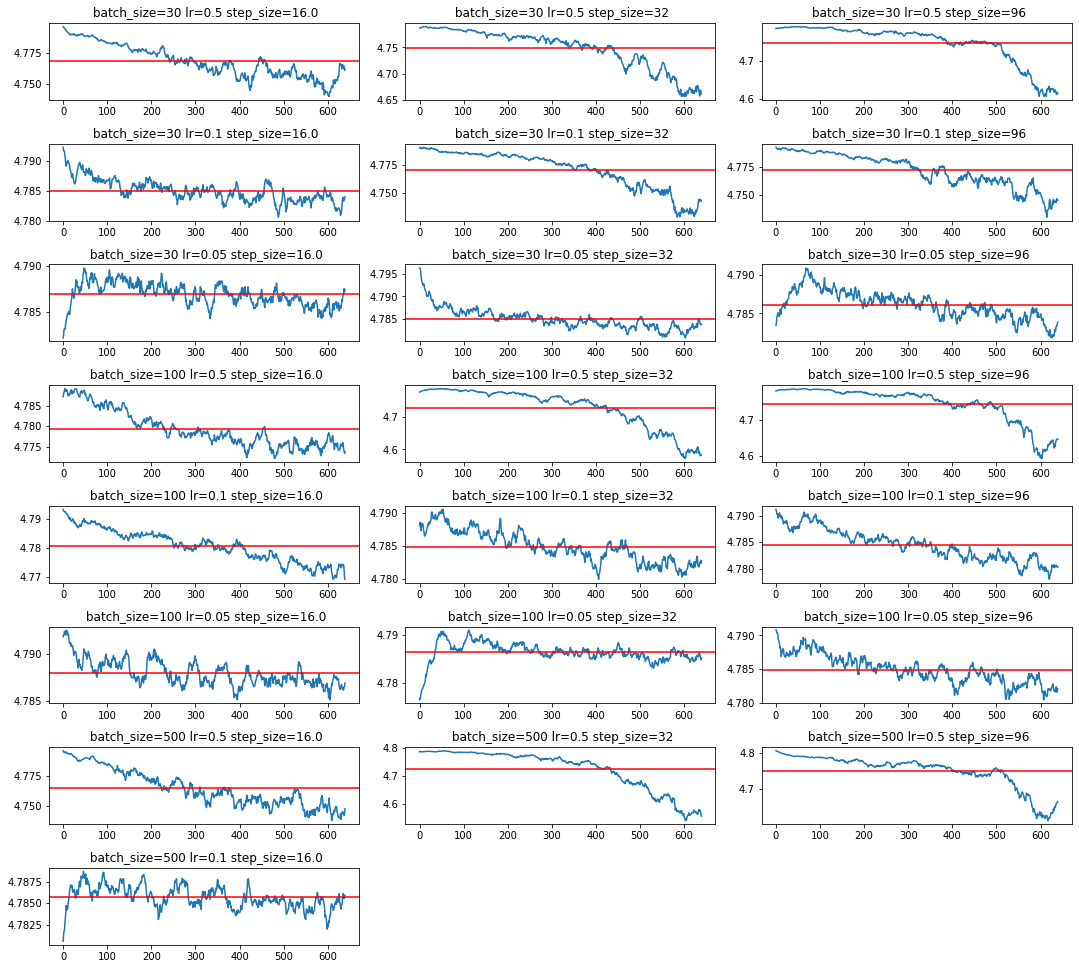

0.08343334595362345  minutes.


In [60]:
fig = plt.figure(figsize=(15, 15))

for i in range(len(all_params_loss)):
    j = i+1
    ax = fig.add_subplot(9, 3, j)
    plt.tight_layout()
    plt.title(all_params_loss[i][0])
    plt.plot(all_params_loss[i][1])
    plt.axhline(y=torch.mean(torch.stack(all_params_loss[i][1])).item(), color='r', linestyle='-')
    axes = plt.gca()
    #axes.set_ylim([1.5,5])

    #plt.axis('tight')

# Transfer Learning

In [105]:
def train_model(model, criterion, optimizer, scheduler, loader, max_lr = 0.5, min_lr = 0.01,  num_epochs=25):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    lr_find_loss = []
    lr_find_lr = []
    itera = 0
    k = 0
    
    step_size = len(loader)
    print(step_size)
    clr = cyclical_lr(step_size, min_lr, max_lr)
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in loader:
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    labels = labels - 1

                    loss = criterion(outputs, labels.long())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()
                    if itera % (step_size*2) == 0 :
                        max_lr = max_lr * np.exp(-1*(0.1 + ((1/10)*k)))
                        k += 0.5
                        clr = cyclical_lr(step_size, min_lr, max_lr)
                        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])
                    lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
                    lr_find_lr.append(lr_step) 

                    if itera==0:
                      lr_find_loss.append(loss)
                    else:
                      loss = smoothing  * loss + (1 - smoothing) * lr_find_loss[-1]
                      lr_find_loss.append(loss)
                    itera += 1

            epoch_loss = running_loss / len(loader)
            epoch_acc = running_corrects.double() / len(loader)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if(phase == 'val'):
                preds_files = []
                labels_files = []
                for batch in mini_test_loader:
                    images, labels = batch
                    preds = model(images)
                    _, out = torch.max(preds, 1)
                    preds_files.append(out)
                    labels_files.append(labels.data - 1)
                    
                sums = 0
                pre = 0
                for i in range(len(preds_files)):
                    sums += torch.sum(preds_files[i] == labels_files[i]).item() + 1
                    pre += precision_score(np.array(preds_files[i]), np.array(labels_files[i]), average = 'macro')

                print('percentage accuracy test data : ', sums/len(mini_test_loader.dataset))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return (model, lr_find_loss, lr_find_lr)

In [64]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './Images'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

FileNotFoundError: [Errno 2] No such file or directory: './Images/train'

In [106]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 120)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer_ft, [exp_lr_scheduler])

step_size = len(mini_train_loader)

start_lr = 0.5
optimizer = torch.optim.SGD(model_ft.parameters(), start_lr)
#for g in optimizer.param_groups:
#    g['lr'] == 0.001
    
max_lr = 0.5
min_lr = 0.01
clr = cyclical_lr(step_size, min_lr, max_lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])

##########################################################################################################
##########################################################################################################

In [108]:
model_ft, loss_data, lr_data = train_model(model_ft, criterion, optimizer, scheduler, mini_train_loader,
                       num_epochs=3)

64
Epoch 0/2
----------
train Loss: 141.7446 Acc: 3.0312
val Loss: 238.9732 Acc: 0.5469
percentage accuracy test data :  0.03515625

Epoch 1/2
----------
train Loss: 90.1032 Acc: 11.3438
val Loss: 23.0266 Acc: 27.3750
percentage accuracy test data :  0.51171875

Epoch 2/2
----------
train Loss: 33.0475 Acc: 23.5156
val Loss: 90.9028 Acc: 10.9688
percentage accuracy test data :  0.23828125

Best val Acc: 27.375000


21.11109403371811  minutes.


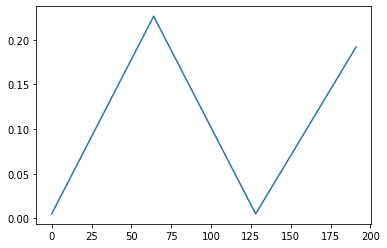

In [109]:
plt.plot(lr_data)

In [87]:
preds_files = []
labels_files = []
for batch in mini_test_loader:
    images, labels = batch
    preds = model_ft(images)
    _, out = torch.max(preds, 1)
    print(len(out ))
    preds_files.append(out)
    labels_files.append(labels.data - 1)

32
32
32
32
32
32
32
32


0.17753518025080364  minutes.


In [94]:
sums = 0
pre = 0
for i in range(len(preds_files)):
    sums += torch.sum(preds_files[i] == labels_files[i]).item() + 1
    pre += precision_score(np.array(preds_files[i]), np.array(labels_files[i]), average = 'macro')

print(sums)
print(sums/len(mini_test_loader.dataset))
print(pre/8)

139
0.54296875
0.3721620286627507


In [95]:
np.sum(np.array(preds_files[0]) == np.array(labels_files[0]))

14

In [96]:
accuracy_score(np.array(preds_files[1]), np.array(labels_files[1]))

0.625

In [97]:
precision_score(np.array(preds_files[1]), np.array(labels_files[1]), average = 'macro')

0.4625